In [4]:
import pretty_midi
import pandas as pd
import os
from tqdm import tqdm_notebook
import pickle
import shutil
import ast
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Create data

In [11]:
metadata = pd.read_csv('data/maestro-v2.0.0/maestro-v2.0.0.csv')

len(metadata)

%timeit pretty_midi.PrettyMIDI(os.path.join('data/maestro-v2.0.0', row['midi_filename']))

songs = []
for _, row in tqdm_notebook(list(metadata.iterrows())):
    midi = pretty_midi.PrettyMIDI(os.path.join('data/maestro-v2.0.0', row['midi_filename']))
    midi.split = row['split']
    songs.append(midi)

shutil.rmtree('data/songs.txt', ignore_errors=True)
for midi in tqdm_notebook(songs):
    assert len(midi.instruments) == 1
    with open('data/songs.txt', 'a') as f:
        f.write('{split}#{tempo}#{notes}\n'.format(
            split=midi.split, tempo=midi.estimate_tempo(), 
            notes=[(n.start, n.end, n.pitch, n.velocity) for n in midi.instruments[0].notes]
        ))

# Create labelled dataset

In [5]:
class Note:
    
    def __init__(self, start, end, pitch, velocity):
        self.start = start
        self.end = end
        self.pitch = pitch
        self.velocity = velocity

In [6]:
def process_string(s):
    split, tempo, notes = s.split('#')
    tempo = float(tempo)
    notes = [Note(*tpl) for tpl in ast.literal_eval(notes)]
    return split, tempo, notes

In [7]:
def create_features(notes, nb_timesteps):
    sequences = []
    labels = []
    for i in range(nb_timesteps, len(notes)):
        sequences.append(np.array([n.pitch for n in notes[i - nb_timesteps:i]]))
        labels.append(notes[i].pitch)
    return sequences, labels

In [8]:
nb_lines = 0
with open('data/songs.txt') as f:
    for line in f:
        nb_lines += 1

In [13]:
count_by_pitch = np.zeros(shape=128)
with open('data/songs.txt') as f:
    for line in tqdm_notebook(f, total=nb_lines):
        split, tempo, notes = process_string(line)
        for note in notes:
            count_by_pitch[note.pitch] += 1

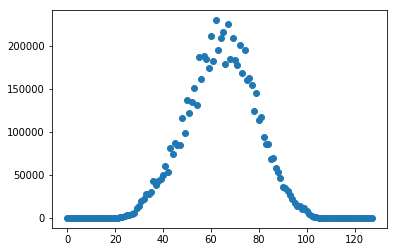

In [58]:
plt.scatter(*zip(*list(enumerate(count_by_pitch))))

In [9]:
def constrain_pitch(pitch, min_pitch, max_pitch):
    if pitch < min_pitch:
        pitch = pitch % 12 + 12 * (min_pitch // 12) + 12
        if pitch >= min_pitch + 12:
            pitch -= 12
        assert min_pitch <= pitch < min_pitch + 12
        return pitch
    if pitch > max_pitch:
        pitch = pitch % 12 + 12 * (max_pitch // 12) - 12
        if pitch <= max_pitch - 12:
            pitch += 12
        assert max_pitch - 12 < pitch <= max_pitch
        return pitch
    return pitch

In [15]:
x_train = []
y_train = []
x_validate = []
y_validate = []

In [16]:
min_pitch = 40
max_pitch = 80
nb_pitches = max_pitch - min_pitch + 1

In [17]:
timesteps = 20

In [18]:
# sample_fraction = 0.1

24GB with pitch 40-80, timesteps=20

In [19]:
random.seed(0)
with open('data/songs.txt') as f:
    for line in tqdm_notebook(f, total=nb_lines):
        split, tempo, notes = process_string(line)
        for note in notes:
            note.pitch = constrain_pitch(note.pitch, min_pitch, max_pitch) - min_pitch
        sequences, labels = create_features(notes, nb_timesteps=timesteps)
        if split == 'train':
            x_train.extend(sequences)
            y_train.extend(labels)
        elif split == 'validation':
            x_validate.extend(sequences)
            y_validate.extend(labels)

In [20]:
x_train = to_categorical(np.array(x_train), num_classes=nb_pitches)
y_train = to_categorical(np.array(y_train), num_classes=nb_pitches)
x_validate = to_categorical(np.array(x_validate), num_classes=nb_pitches)
y_validate = to_categorical(np.array(y_validate), num_classes=nb_pitches)

In [23]:
model = Sequential()

# Recurrent layer
model.add(LSTM(64, input_shape=(timesteps, nb_pitches),
               return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(nb_pitches, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('models/model.h5', save_best_only=True, save_weights_only=False)]

In [25]:
x_train.shape

(5975834, 20, 41)

In [26]:
y_train.shape

(5975834, 41)

In [27]:
x_validate.shape

(657246, 20, 41)

In [28]:
y_validate.shape

(657246, 41)

In [29]:
history = model.fit(x_train,  y_train, 
                    batch_size=2048, epochs=150,
                    callbacks=callbacks,
                    validation_data=(x_validate, y_validate))

W0629 15:47:10.039770 140133684045568 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 5975834 samples, validate on 657246 samples
Epoch 1/150
 559104/5975834 [=>............................] - ETA: 17:19 - loss: 3.4375 - accuracy: 0.0810

KeyboardInterrupt: 